# Simulated Annealing Demo

Skrypt przedstawia przykładową implementację algorytmu symulowanego wyżarzania (ang. Simulated Annealing, SA) i jego zastosowanie do rozwiązywania problemu Quadratic Assignment Problem (QAP). Problem jest dokładnie opisany m.in. w pracy Burkarda i innych [1]. Popularne instancje problemu QAP można znaleźć w bibliotece QAPLib [2]. Skrypt skupia się na rozwiązywaniu instancji NUG12 [3], w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu.

Literatura:

[1]  Burkard, R., Cela, E., Pardalos, P., Pitsoulis, L., "The Quadratic Assignment Problem", http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.217.1914

[2] QAPLIB, http://anjos.mgi.polymtl.ca/qaplib/

[3] NUG12, http://anjos.mgi.polymtl.ca/qaplib/data.d/nug12.dat

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import time
import urllib.request
import scipy.stats

%matplotlib inline

In [18]:
QAP_INSTANCE_URL = 'http://anjos.mgi.polymtl.ca/qaplib/data.d/nug12.dat'

## Reading input data

In [8]:
qap_instance_file = urllib.request.urlopen(QAP_INSTANCE_URL)

line = qap_instance_file.readline()
n = int(line.decode()[:-1].split()[0])
print('Problem size: %d' % n)

A = np.empty((n, n))
qap_instance_file.readline()
for i in range(n):
    line = qap_instance_file.readline()
    A[i, :] = list(map(int, line.decode()[:-1].split()))
print('Flow matrix:\n', A)

B = np.empty((n, n))
qap_instance_file.readline()
for i in range(n):
    line = qap_instance_file.readline()
    B[i, :] = list(map(int, line.decode()[:-1].split()))
print('Distance matrix:\n', B)

Problem size: 12
Flow matrix:
 [[0. 1. 2. 3. 1. 2. 3. 4. 2. 3. 4. 5.]
 [1. 0. 1. 2. 2. 1. 2. 3. 3. 2. 3. 4.]
 [2. 1. 0. 1. 3. 2. 1. 2. 4. 3. 2. 3.]
 [3. 2. 1. 0. 4. 3. 2. 1. 5. 4. 3. 2.]
 [1. 2. 3. 4. 0. 1. 2. 3. 1. 2. 3. 4.]
 [2. 1. 2. 3. 1. 0. 1. 2. 2. 1. 2. 3.]
 [3. 2. 1. 2. 2. 1. 0. 1. 3. 2. 1. 2.]
 [4. 3. 2. 1. 3. 2. 1. 0. 4. 3. 2. 1.]
 [2. 3. 4. 5. 1. 2. 3. 4. 0. 1. 2. 3.]
 [3. 2. 3. 4. 2. 1. 2. 3. 1. 0. 1. 2.]
 [4. 3. 2. 3. 3. 2. 1. 2. 2. 1. 0. 1.]
 [5. 4. 3. 2. 4. 3. 2. 1. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0.  5.  2.  4.  1.  0.  0.  6.  2.  1.  1.  1.]
 [ 5.  0.  3.  0.  2.  2.  2.  0.  4.  5.  0.  0.]
 [ 2.  3.  0.  0.  0.  0.  0.  5.  5.  2.  2.  2.]
 [ 4.  0.  0.  0.  5.  2.  2. 10.  0.  0.  5.  5.]
 [ 1.  2.  0.  5.  0. 10.  0.  0.  0.  5.  1.  1.]
 [ 0.  2.  0.  2. 10.  0.  5.  1.  1.  5.  4.  0.]
 [ 0.  2.  0.  2.  0.  5.  0. 10.  5.  2.  3.  3.]
 [ 6.  0.  5. 10.  0.  1. 10.  0.  0.  0.  5.  0.]
 [ 2.  4.  5.  0.  0.  1.  5.  0.  0.  0. 10. 10.]
 [ 1.  5.  2.  0.  5.  

## Objective function

In [19]:
def qap_objective_function(p, A, B):
    s = 0.0
    for i in range(A.shape[0]):
        s += (A[i, :] * B[p[i], p]).sum()
    return s


In [21]:
p = [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]
print(qap_objective_function(p, A, B), p)

578.0 [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]


## Random Sampling

In [11]:
t0 = time.time()

T = 1000000

permutations = np.empty((T, n), dtype=np.int64)
costs = np.zeros(T)
for i in range(T):
    permutations[i, :] = np.random.permutation(n)
    costs[i] = qap_objective_function(permutations[i, :])

print(time.time() - t0)

p = permutations[costs.argmin(), :]
print(qap_objective_function(p), p)

80.63478088378906
594.0 [11  3 10  4  8  7  6  5  2  0  1  9]


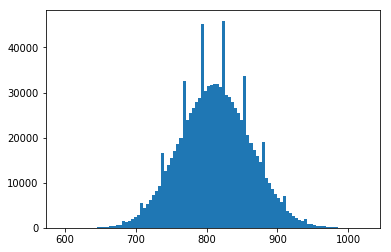

811.971136 49.69995258417764


In [12]:
plt.figure()
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

## Simulated Annealing

In [14]:
def random_neighbor(p, radius):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q


In [26]:
def get_permutations_distance(p, q):
    return (1 - scipy.stats.kendalltau(p, q)[0]) / 2


def simulated_annealing(radius, alpha, A, B, iter_count):
    p = np.random.permutation(A.shape[0])
    p_cost = qap_objective_function(p, A, B)
    costs, successes, accepted_fails = np.zeros(iter_count), np.zeros(iter_count), np.zeros(iter_count)
    perm_distances, cost_distances = np.ones(iter_count) * -1, np.ones(iter_count) * -1 
    for t in range(iter_count):
        if t % 10000 == 0:
            print("Iteration {}...".format(t))
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q, A, B)
        if q_cost < p_cost:
            p, p_cost = q, q_cost
            successes[t] = True
            perm_distances[t] = get_permutations_distance(p, q)
            cost_distances[t] = p_cost - q_cost
        elif np.random.rand() < np.exp(-alpha * (q_cost - p_cost) * t/T):
            p, p_cost = q, q_cost
            accepted_fails[t] = True
        costs[t] = p_cost
    print(time.time() - t0, costs.min())
    return costs, successes, accepted_fails, perm_distances, cost_distances


def plot_success_rate(successes, accepted_fails):
    plt.figure(figsize=(12, 8))
    plt.bar(np.arange(successes.shape[0]), successes.reshape(-1, 100).sum(axis=1))
    plt.bar(np.arange(accepted_fails.shape[0]), accepted_fails.reshape(-1, 100).sum(axis=1))
    plt.plot()


def plot_distance_dependencies(perm_distances, cost_distances):
    plt.figure(figsize=(12, 8))
    normalized_distances = perm_distances * cost_distances[0]
    plt.bar(np.arange(normalized_distances.shape[0]), normalized_distances.reshape(-1, 100).sum(axis=1))
    plt.bar(np.arange(cost_distances.shape[0]), cost_distances.reshape(-1, 100).sum(axis=1))
    plt.plot()


def plot_optimal_solutions(radius, alpha, A, B, iter_count, sample_count):
    costs = np.zeros(sample_count)
    for i in range(sample_count):
        costs[i] = np.min(simulated_annealing(radius, alpha, A, B, iter_count)[0])
    plt.figure(figsize=(12, 8))
    plt.scatter(np.arange(costs.shape[0]), costs)
    plt.plot()   

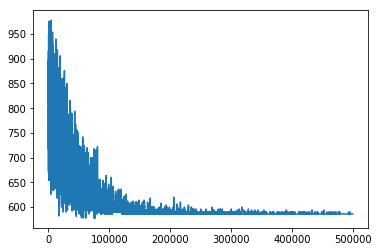

In [16]:
plt.figure()
plt.plot(costs)
plt.show()